In [1]:
!cd /kaggle/working/
!rm -rf *

In [2]:
import shutil
import os

input_path = "/kaggle/input/realwaste-dataset/realwaste-main/RealWaste"

working_path = "/kaggle/working/realwaste"

shutil.copytree(input_path, working_path, dirs_exist_ok=True)

print("Dataset copied successfully to working directory!")

Dataset copied successfully to working directory!


In [3]:
base_dir = "/kaggle/working/realwaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Textile Trash: 318 images
Cardboard: 461 images
Miscellaneous Trash: 495 images
Glass: 420 images
Vegetation: 436 images
Food Organics: 411 images
Plastic: 921 images
Metal: 790 images
Paper: 500 images


In [4]:
!pip install split-folders

In [5]:
import splitfolders

input_folder = "/kaggle/working/realwaste"
output_folder = "/kaggle/working/realwaste-split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:01, 4333.68 files/s]


In [47]:
base_dir = "/kaggle/working/realwaste-split"

for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f"Total {split}: {total} images")


TRAIN SET
  Textile Trash: 222 images
  Cardboard: 322 images
  Miscellaneous Trash: 346 images
  Glass: 294 images
  Vegetation: 305 images
  Food Organics: 287 images
  Plastic: 644 images
  Metal: 553 images
  Paper: 350 images
Total train: 3323 images

VAL SET
  Textile Trash: 47 images
  Cardboard: 69 images
  Miscellaneous Trash: 74 images
  Glass: 63 images
  Vegetation: 65 images
  Food Organics: 61 images
  Plastic: 138 images
  Metal: 118 images
  Paper: 75 images
Total val: 710 images

TEST SET
  Textile Trash: 49 images
  Cardboard: 70 images
  Miscellaneous Trash: 75 images
  Glass: 63 images
  Vegetation: 66 images
  Food Organics: 63 images
  Plastic: 139 images
  Metal: 119 images
  Paper: 75 images
Total test: 719 images


In [48]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_dataset = datasets.ImageFolder("/kaggle/working/realwaste-split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/kaggle/working/realwaste-split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/kaggle/working/realwaste-split/test", transform=val_test_transforms)

# Get number of classes and device early
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 9


In [49]:
class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("\nClass counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\nClass weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [322 287 294 553 346 350 644 222 305]

Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279


In [50]:
BATCH_SIZE = 64

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"\nWeightedRandomSampler created successfully!")
print(f"Total samples in epoch: {len(sample_weights)}")
print(f"Training Batch size: {train_loader.batch_size}")
print(f"Validation Batch size: {val_loader.batch_size}")
print(f"Total training batches per epoch: {len(train_loader)}")


WeightedRandomSampler created successfully!
Total samples in epoch: 3323
Training Batch size: 64
Validation Batch size: 64
Total training batches per epoch: 52


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy

class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._to_linear = None
        self.calculate_flatten_size(256)

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def calculate_flatten_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self._to_linear)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [52]:

def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad()
            outputs = model_instance(images)
            loss = criterion_obj(outputs, labels)
            loss.backward()
            optimizer_obj.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step()

        model_instance.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run)

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

In [55]:
print("\n" + "="*75)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*75 + "\n")

_ = get_fresh_model_for_comparison(num_classes, device)

NUM_EPOCHS_COMP = 20
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=0.000125, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.005, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.005, momentum=0.8, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# 4. RMSProp Optimizer Configuration
model_rmsprop_comp = get_fresh_model_for_comparison(num_classes, device)
optimizer_rmsprop_comp = optim.RMSprop(model_rmsprop_comp.parameters(), lr=0.0005, alpha=0.85, weight_decay=1e-4)
scheduler_rmsprop_comp = StepLR(optimizer_rmsprop_comp, step_size=10, gamma=0.1)


# ===================== TRAINING =====================
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results


sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results


sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results


rmsprop_results = run_optimizer_training_comparison(
    model_rmsprop_comp, "RMSProp", optimizer_rmsprop_comp, criterion_comp, scheduler_rmsprop_comp,
    NUM_EPOCHS_COMP, train_loader, val_loader, device
)
rmsprop_train_losses, rmsprop_train_accuracies, rmsprop_val_losses, rmsprop_val_accuracies, rmsprop_comp_model_path = rmsprop_results


print("\nOptimizer comparison training completed for all models.")



       Starting Optimizer Performance Comparison Training       


Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 2.1282 | Train Acc: 36.62% | Val Loss: 1.3793 | Val Accuracy: 49.58%


  Adam - Epoch [2/20] Train Loss: 1.3688 | Train Acc: 50.80% | Val Loss: 1.3412 | Val Accuracy: 49.86%


  Adam - Epoch [3/20] Train Loss: 1.2349 | Train Acc: 54.14% | Val Loss: 1.2497 | Val Accuracy: 54.65%


  Adam - Epoch [4/20] Train Loss: 1.1471 | Train Acc: 56.73% | Val Loss: 1.1743 | Val Accuracy: 59.58%


  Adam - Epoch [5/20] Train Loss: 1.0435 | Train Acc: 60.88% | Val Loss: 1.1289 | Val Accuracy: 59.30%


  Adam - Epoch [6/20] Train Loss: 0.9786 | Train Acc: 63.59% | Val Loss: 1.0766 | Val Accuracy: 62.82%


  Adam - Epoch [7/20] Train Loss: 0.9011 | Train Acc: 66.78% | Val Loss: 0.9925 | Val Accuracy: 64.79%


  Adam - Epoch [8/20] Train Loss: 0.8594 | Train Acc: 69.30% | Val Loss: 0.9908 | Val Accuracy: 64.93%


  Adam - Epoch [9/20] Train Loss: 0.7501 | Train Acc: 73.10% | Val Loss: 0.9219 | Val Accuracy: 69.15%


  Adam - Epoch [10/20] Train Loss: 0.7075 | Train Acc: 74.00% | Val Loss: 0.9026 | Val Accuracy: 69.58%


  Adam - Epoch [11/20] Train Loss: 0.6285 | Train Acc: 76.86% | Val Loss: 0.8545 | Val Accuracy: 69.44%


  Adam - Epoch [12/20] Train Loss: 0.5601 | Train Acc: 79.63% | Val Loss: 0.8602 | Val Accuracy: 70.14%


  Adam - Epoch [13/20] Train Loss: 0.5564 | Train Acc: 80.65% | Val Loss: 0.8614 | Val Accuracy: 69.01%


  Adam - Epoch [14/20] Train Loss: 0.5310 | Train Acc: 81.37% | Val Loss: 0.8372 | Val Accuracy: 70.28%


  Adam - Epoch [15/20] Train Loss: 0.5335 | Train Acc: 80.53% | Val Loss: 0.8354 | Val Accuracy: 70.42%


  Adam - Epoch [16/20] Train Loss: 0.5099 | Train Acc: 81.94% | Val Loss: 0.8408 | Val Accuracy: 70.99%


  Adam - Epoch [17/20] Train Loss: 0.5081 | Train Acc: 81.82% | Val Loss: 0.8337 | Val Accuracy: 70.28%


  Adam - Epoch [18/20] Train Loss: 0.4967 | Train Acc: 81.94% | Val Loss: 0.8143 | Val Accuracy: 71.41%


  Adam - Epoch [19/20] Train Loss: 0.4826 | Train Acc: 82.70% | Val Loss: 0.8256 | Val Accuracy: 72.11%


  Adam - Epoch [20/20] Train Loss: 0.4852 | Train Acc: 83.15% | Val Loss: 0.8103 | Val Accuracy: 72.39%
--- Adam training finished. Best Val Accuracy: 72.39% ---

Training with Standard SGD for 20 epochs...


  Standard SGD - Epoch [1/20] Train Loss: 1.7624 | Train Acc: 36.14% | Val Loss: 1.4742 | Val Accuracy: 48.31%


  Standard SGD - Epoch [2/20] Train Loss: 1.3755 | Train Acc: 50.26% | Val Loss: 1.4857 | Val Accuracy: 45.35%


  Standard SGD - Epoch [3/20] Train Loss: 1.1984 | Train Acc: 57.66% | Val Loss: 1.1681 | Val Accuracy: 57.04%


  Standard SGD - Epoch [4/20] Train Loss: 1.0718 | Train Acc: 61.87% | Val Loss: 1.1711 | Val Accuracy: 60.70%


  Standard SGD - Epoch [5/20] Train Loss: 0.9767 | Train Acc: 65.57% | Val Loss: 1.1052 | Val Accuracy: 62.82%


  Standard SGD - Epoch [6/20] Train Loss: 0.9424 | Train Acc: 66.57% | Val Loss: 1.0097 | Val Accuracy: 66.62%


  Standard SGD - Epoch [7/20] Train Loss: 0.8271 | Train Acc: 71.20% | Val Loss: 0.9569 | Val Accuracy: 66.62%


  Standard SGD - Epoch [8/20] Train Loss: 0.7791 | Train Acc: 72.46% | Val Loss: 1.0264 | Val Accuracy: 62.82%


  Standard SGD - Epoch [9/20] Train Loss: 0.7068 | Train Acc: 75.84% | Val Loss: 0.9262 | Val Accuracy: 67.18%


  Standard SGD - Epoch [10/20] Train Loss: 0.6471 | Train Acc: 77.88% | Val Loss: 0.9153 | Val Accuracy: 68.17%


  Standard SGD - Epoch [11/20] Train Loss: 0.5310 | Train Acc: 83.15% | Val Loss: 0.8611 | Val Accuracy: 70.85%


  Standard SGD - Epoch [12/20] Train Loss: 0.5205 | Train Acc: 84.05% | Val Loss: 0.8468 | Val Accuracy: 71.69%


  Standard SGD - Epoch [13/20] Train Loss: 0.5003 | Train Acc: 83.87% | Val Loss: 0.8281 | Val Accuracy: 70.99%


  Standard SGD - Epoch [14/20] Train Loss: 0.4850 | Train Acc: 85.34% | Val Loss: 0.8377 | Val Accuracy: 71.97%


  Standard SGD - Epoch [15/20] Train Loss: 0.4833 | Train Acc: 84.47% | Val Loss: 0.8313 | Val Accuracy: 71.83%


  Standard SGD - Epoch [16/20] Train Loss: 0.4925 | Train Acc: 84.44% | Val Loss: 0.8233 | Val Accuracy: 71.69%


  Standard SGD - Epoch [17/20] Train Loss: 0.4774 | Train Acc: 85.95% | Val Loss: 0.8298 | Val Accuracy: 71.55%


  Standard SGD - Epoch [18/20] Train Loss: 0.4645 | Train Acc: 85.68% | Val Loss: 0.8148 | Val Accuracy: 72.11%


  Standard SGD - Epoch [19/20] Train Loss: 0.4660 | Train Acc: 85.83% | Val Loss: 0.8133 | Val Accuracy: 71.69%


  Standard SGD - Epoch [20/20] Train Loss: 0.4497 | Train Acc: 86.43% | Val Loss: 0.8136 | Val Accuracy: 72.39%
--- Standard SGD training finished. Best Val Accuracy: 72.39% ---

Training with SGD with Momentum for 20 epochs...


  SGD with Momentum - Epoch [1/20] Train Loss: 1.9190 | Train Acc: 31.96% | Val Loss: 1.5850 | Val Accuracy: 36.06%


  SGD with Momentum - Epoch [2/20] Train Loss: 1.5950 | Train Acc: 39.78% | Val Loss: 1.4926 | Val Accuracy: 44.08%


  SGD with Momentum - Epoch [3/20] Train Loss: 1.5034 | Train Acc: 42.67% | Val Loss: 1.3163 | Val Accuracy: 53.94%


  SGD with Momentum - Epoch [4/20] Train Loss: 1.4059 | Train Acc: 45.44% | Val Loss: 1.3454 | Val Accuracy: 48.73%


  SGD with Momentum - Epoch [5/20] Train Loss: 1.3758 | Train Acc: 46.31% | Val Loss: 1.2097 | Val Accuracy: 55.49%


  SGD with Momentum - Epoch [6/20] Train Loss: 1.2729 | Train Acc: 51.73% | Val Loss: 1.3386 | Val Accuracy: 49.01%


  SGD with Momentum - Epoch [7/20] Train Loss: 1.2519 | Train Acc: 51.58% | Val Loss: 1.5283 | Val Accuracy: 51.83%


  SGD with Momentum - Epoch [8/20] Train Loss: 1.2095 | Train Acc: 52.93% | Val Loss: 1.1562 | Val Accuracy: 57.75%


  SGD with Momentum - Epoch [9/20] Train Loss: 1.1916 | Train Acc: 54.32% | Val Loss: 1.1148 | Val Accuracy: 58.87%


  SGD with Momentum - Epoch [10/20] Train Loss: 1.1360 | Train Acc: 54.92% | Val Loss: 1.1899 | Val Accuracy: 56.48%


  SGD with Momentum - Epoch [11/20] Train Loss: 1.0164 | Train Acc: 59.43% | Val Loss: 1.0052 | Val Accuracy: 62.54%


  SGD with Momentum - Epoch [12/20] Train Loss: 0.9197 | Train Acc: 63.05% | Val Loss: 0.9898 | Val Accuracy: 62.11%


  SGD with Momentum - Epoch [13/20] Train Loss: 0.9022 | Train Acc: 64.07% | Val Loss: 0.9706 | Val Accuracy: 64.08%


  SGD with Momentum - Epoch [14/20] Train Loss: 0.8898 | Train Acc: 64.67% | Val Loss: 0.9638 | Val Accuracy: 63.94%


  SGD with Momentum - Epoch [15/20] Train Loss: 0.8701 | Train Acc: 64.88% | Val Loss: 0.9760 | Val Accuracy: 64.37%


  SGD with Momentum - Epoch [16/20] Train Loss: 0.8481 | Train Acc: 66.90% | Val Loss: 0.9463 | Val Accuracy: 64.51%


  SGD with Momentum - Epoch [17/20] Train Loss: 0.8397 | Train Acc: 66.45% | Val Loss: 0.9751 | Val Accuracy: 64.65%


  SGD with Momentum - Epoch [18/20] Train Loss: 0.8461 | Train Acc: 67.23% | Val Loss: 0.9349 | Val Accuracy: 64.23%


  SGD with Momentum - Epoch [19/20] Train Loss: 0.8186 | Train Acc: 66.87% | Val Loss: 0.9362 | Val Accuracy: 65.92%


  SGD with Momentum - Epoch [20/20] Train Loss: 0.8114 | Train Acc: 66.93% | Val Loss: 0.9370 | Val Accuracy: 65.77%
--- SGD with Momentum training finished. Best Val Accuracy: 65.92% ---

Training with RMSProp for 20 epochs...


  RMSProp - Epoch [1/20] Train Loss: 8.8430 | Train Acc: 25.55% | Val Loss: 1.8283 | Val Accuracy: 28.87%


  RMSProp - Epoch [2/20] Train Loss: 2.0229 | Train Acc: 28.11% | Val Loss: 1.8087 | Val Accuracy: 34.23%


  RMSProp - Epoch [3/20] Train Loss: 2.8762 | Train Acc: 28.14% | Val Loss: 2.6621 | Val Accuracy: 30.00%


  RMSProp - Epoch [4/20] Train Loss: 2.2825 | Train Acc: 37.77% | Val Loss: 1.6055 | Val Accuracy: 44.37%


  RMSProp - Epoch [5/20] Train Loss: 1.6168 | Train Acc: 45.17% | Val Loss: 1.7948 | Val Accuracy: 44.23%


  RMSProp - Epoch [6/20] Train Loss: 1.6376 | Train Acc: 48.39% | Val Loss: 1.3892 | Val Accuracy: 52.54%


  RMSProp - Epoch [7/20] Train Loss: 1.3162 | Train Acc: 55.40% | Val Loss: 1.1959 | Val Accuracy: 55.77%


  RMSProp - Epoch [8/20] Train Loss: 1.1501 | Train Acc: 60.16% | Val Loss: 1.3153 | Val Accuracy: 52.54%


  RMSProp - Epoch [9/20] Train Loss: 1.1370 | Train Acc: 61.75% | Val Loss: 1.1573 | Val Accuracy: 60.00%


  RMSProp - Epoch [10/20] Train Loss: 1.0334 | Train Acc: 64.73% | Val Loss: 1.2261 | Val Accuracy: 56.62%


  RMSProp - Epoch [11/20] Train Loss: 0.7738 | Train Acc: 73.10% | Val Loss: 0.8570 | Val Accuracy: 69.44%


  RMSProp - Epoch [12/20] Train Loss: 0.6539 | Train Acc: 76.77% | Val Loss: 0.8524 | Val Accuracy: 70.85%


  RMSProp - Epoch [13/20] Train Loss: 0.5984 | Train Acc: 79.18% | Val Loss: 0.8167 | Val Accuracy: 72.25%


  RMSProp - Epoch [14/20] Train Loss: 0.6013 | Train Acc: 79.60% | Val Loss: 0.8167 | Val Accuracy: 72.68%


  RMSProp - Epoch [15/20] Train Loss: 0.5739 | Train Acc: 78.81% | Val Loss: 0.7976 | Val Accuracy: 73.10%


  RMSProp - Epoch [16/20] Train Loss: 0.5401 | Train Acc: 81.04% | Val Loss: 0.7887 | Val Accuracy: 74.08%


  RMSProp - Epoch [17/20] Train Loss: 0.4986 | Train Acc: 82.88% | Val Loss: 0.7774 | Val Accuracy: 74.23%


  RMSProp - Epoch [18/20] Train Loss: 0.4800 | Train Acc: 83.63% | Val Loss: 0.7605 | Val Accuracy: 72.68%


  RMSProp - Epoch [19/20] Train Loss: 0.4570 | Train Acc: 84.14% | Val Loss: 0.7523 | Val Accuracy: 75.35%


  RMSProp - Epoch [20/20] Train Loss: 0.4381 | Train Acc: 85.22% | Val Loss: 0.7700 | Val Accuracy: 75.35%
--- RMSProp training finished. Best Val Accuracy: 75.35% ---

Optimizer comparison training completed for all models.


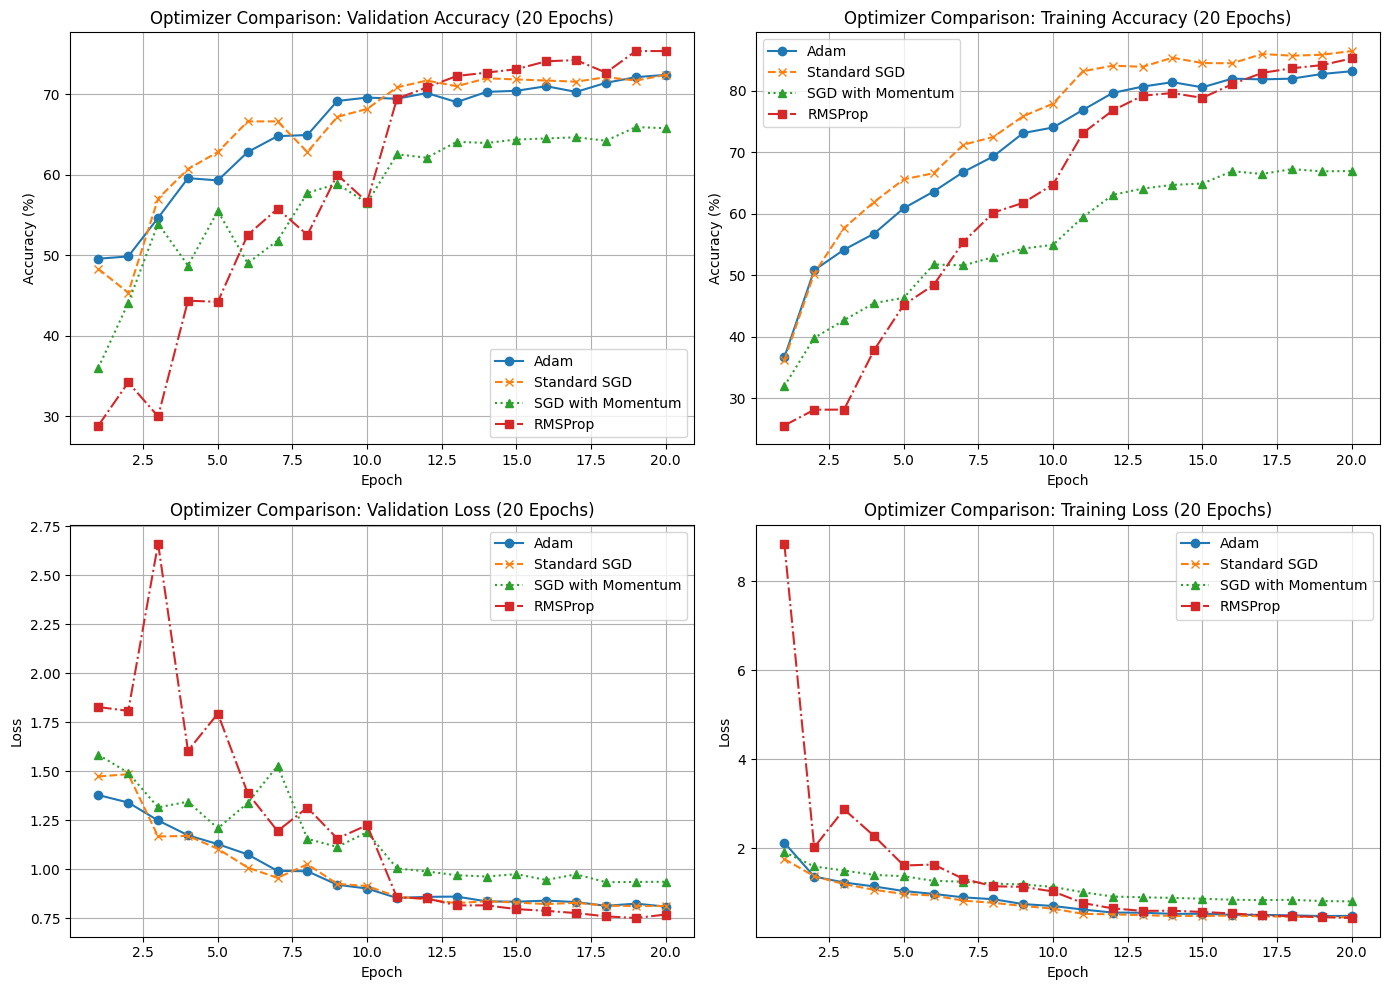


Optimizer Comparison plots generated.


In [56]:
plt.figure(figsize=(14, 10))

# === Plot 1: Validation Accuracy ===
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 2: Training Accuracy ===
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_accuracies, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# === Plot 3: Validation Loss ===
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_val_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Validation Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# === Plot 4: Training Loss ===
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), rmsprop_train_losses, marker='s', linestyle='-.', label='RMSProp')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")


In [57]:
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path))
    model_instance.to(device_comp)
    model_instance.eval()

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy


print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
rmsprop_final_test_accuracy = evaluate_on_test_set_comp(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device)


print("\n" + "="*75)
print("       Optimizer Performance Comparison Summary       ")
print("="*75 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for RMSProp: {rmsprop_final_test_accuracy:.2f}%")

print("\nOptimizer Comparison Test Evaluation Complete.")



--- Evaluating Comparison Models on Test Set ---



       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 75.52%
Final Test Accuracy for Standard SGD: 73.16%
Final Test Accuracy for SGD with Momentum: 69.68%
Final Test Accuracy for RMSProp: 76.91%

Optimizer Comparison Test Evaluation Complete.



--- Generating Confusion Matrices for All Optimizers ---


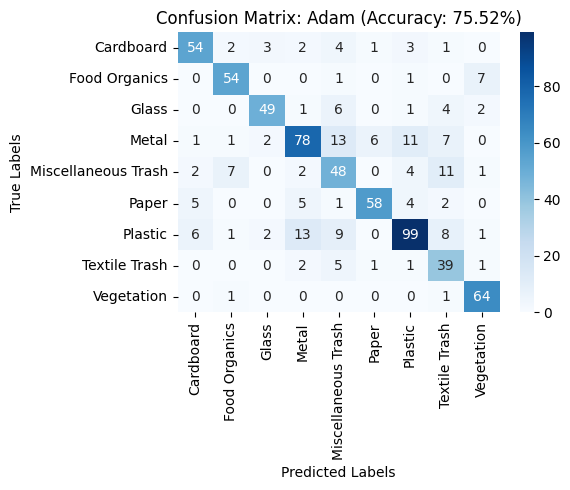

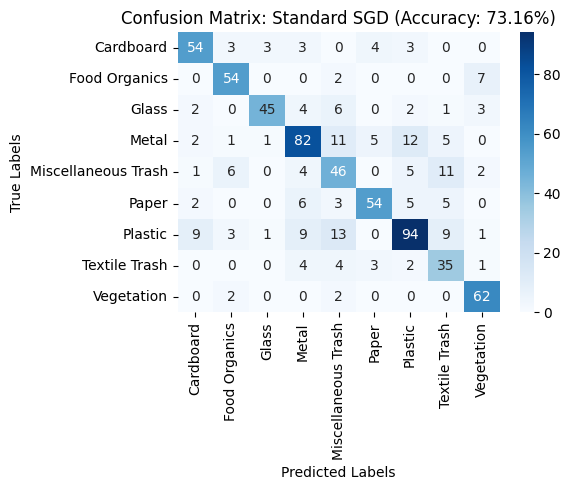

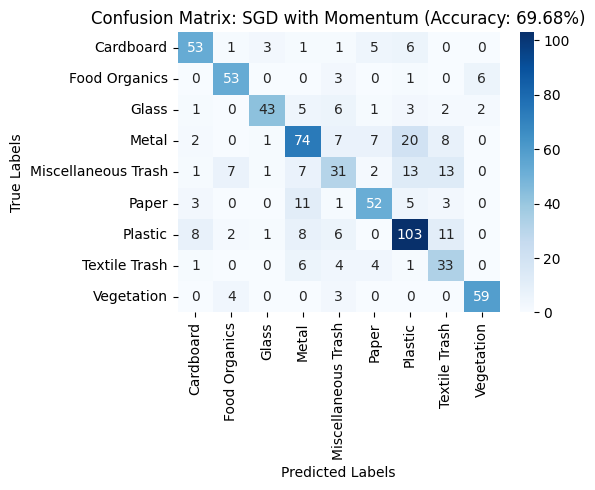

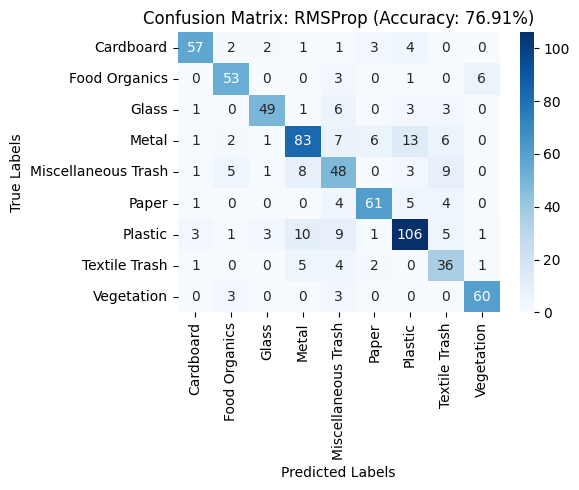


Confusion matrices generated for all optimizer models.


In [58]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, model_path, test_loader, device, optimizer_name, class_names=None):

    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    acc = 100 * np.trace(cm) / np.sum(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {optimizer_name} (Accuracy: {acc:.2f}%)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()


# === Example: Generate confusion matrix for each optimizer ===
print("\n--- Generating Confusion Matrices for All Optimizers ---")

class_names = test_loader.dataset.classes if hasattr(test_loader.dataset, "classes") else None

plot_confusion_matrix(model_adam_comp, adam_comp_model_path, test_loader, device, "Adam", class_names)
plot_confusion_matrix(model_sgd_comp, sgd_comp_model_path, test_loader, device, "Standard SGD", class_names)
plot_confusion_matrix(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device, "SGD with Momentum", class_names)
plot_confusion_matrix(model_rmsprop_comp, rmsprop_comp_model_path, test_loader, device, "RMSProp", class_names)

print("\nConfusion matrices generated for all optimizer models.")


In [37]:
from torchvision import models

NUM_EPOCHS = 20
criterion = nn.CrossEntropyLoss()

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


train_loader_new = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_new = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_new = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

dataloaders = {'train': train_loader_new, 'val': val_loader_new, 'test': test_loader_new}



In [38]:
from torchvision.models import AlexNet_Weights, DenseNet121_Weights

# --- AlexNet ---
alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
for param in alexnet.features.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet = alexnet.to(device)

# --- DenseNet121 ---
densenet = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
for param in densenet.features.parameters():
    param.requires_grad = False
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
densenet = densenet.to(device)


In [39]:
def train_and_validate(model, model_name, optimizer, criterion, dataloaders, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(dataloaders['train'], desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = 100 * correct / total

        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(dataloaders['val'], desc=f"{model_name} Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(dataloaders['val'])
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"{model_name} Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), f"{model_name.lower()}_finetuned.pth")
    print(f"\n{model_name} fine-tuning complete!\n")
    return train_losses, val_losses, train_accuracies, val_accuracies


In [40]:
optimizer_alex = optim.Adam(alexnet.classifier.parameters(), lr=0.00025)
alex_train_losses, alex_val_losses, alex_train_accs, alex_val_accs = train_and_validate(
    alexnet, "AlexNet", optimizer_alex, criterion, dataloaders, num_epochs=NUM_EPOCHS
)

optimizer_dense = optim.Adam(densenet.classifier.parameters(), lr=0.00025)
dense_train_losses, dense_val_losses, dense_train_accs, dense_val_accs = train_and_validate(
    densenet, "DenseNet121", optimizer_dense, criterion, dataloaders, num_epochs=NUM_EPOCHS
)


AlexNet Epoch 1/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [1/20] - Train Loss: 1.2219, Val Loss: 0.8132, Train Acc: 55.76%, Val Acc: 68.59%


AlexNet Epoch 2/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s]


AlexNet Epoch [2/20] - Train Loss: 0.8935, Val Loss: 0.7149, Train Acc: 68.61%, Val Acc: 70.70%


AlexNet Epoch 3/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [3/20] - Train Loss: 0.8072, Val Loss: 0.6441, Train Acc: 71.02%, Val Acc: 75.63%


AlexNet Epoch 4/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s]


AlexNet Epoch [4/20] - Train Loss: 0.7364, Val Loss: 0.5761, Train Acc: 73.31%, Val Acc: 78.45%


AlexNet Epoch 5/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.46it/s]


AlexNet Epoch [5/20] - Train Loss: 0.6715, Val Loss: 0.5826, Train Acc: 76.02%, Val Acc: 78.73%


AlexNet Epoch 6/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [6/20] - Train Loss: 0.6268, Val Loss: 0.5774, Train Acc: 78.33%, Val Acc: 78.59%


AlexNet Epoch 7/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [7/20] - Train Loss: 0.6065, Val Loss: 0.5390, Train Acc: 79.06%, Val Acc: 80.00%


AlexNet Epoch 8/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [8/20] - Train Loss: 0.5993, Val Loss: 0.5572, Train Acc: 78.48%, Val Acc: 78.73%


AlexNet Epoch 9/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [9/20] - Train Loss: 0.5626, Val Loss: 0.5436, Train Acc: 79.81%, Val Acc: 81.13%


AlexNet Epoch 10/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [10/20] - Train Loss: 0.5406, Val Loss: 0.5314, Train Acc: 81.37%, Val Acc: 81.41%


AlexNet Epoch 11/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [11/20] - Train Loss: 0.5102, Val Loss: 0.5207, Train Acc: 82.15%, Val Acc: 80.42%


AlexNet Epoch 12/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [12/20] - Train Loss: 0.5173, Val Loss: 0.5206, Train Acc: 82.58%, Val Acc: 80.14%


AlexNet Epoch 13/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [13/20] - Train Loss: 0.4873, Val Loss: 0.5339, Train Acc: 82.31%, Val Acc: 80.70%


AlexNet Epoch 14/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s]


AlexNet Epoch [14/20] - Train Loss: 0.4736, Val Loss: 0.4736, Train Acc: 83.21%, Val Acc: 83.38%


AlexNet Epoch 15/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s]


AlexNet Epoch [15/20] - Train Loss: 0.4758, Val Loss: 0.4790, Train Acc: 82.97%, Val Acc: 82.68%


AlexNet Epoch 16/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [16/20] - Train Loss: 0.4469, Val Loss: 0.4893, Train Acc: 83.39%, Val Acc: 82.39%


AlexNet Epoch 17/20 [Train]: 100%|██████████| 52/52 [00:35<00:00,  1.45it/s]


AlexNet Epoch [17/20] - Train Loss: 0.4305, Val Loss: 0.5001, Train Acc: 84.74%, Val Acc: 82.11%


AlexNet Epoch 18/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


AlexNet Epoch [18/20] - Train Loss: 0.4335, Val Loss: 0.5083, Train Acc: 84.05%, Val Acc: 82.11%


AlexNet Epoch 19/20 [Train]: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s]


AlexNet Epoch [19/20] - Train Loss: 0.4477, Val Loss: 0.5034, Train Acc: 84.50%, Val Acc: 81.41%


AlexNet Epoch 20/20 [Train]: 100%|██████████| 52/52 [00:37<00:00,  1.40it/s]


AlexNet Epoch [20/20] - Train Loss: 0.4123, Val Loss: 0.4940, Train Acc: 86.01%, Val Acc: 83.10%

AlexNet fine-tuning complete!



DenseNet121 Epoch 1/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [1/20] - Train Loss: 1.9541, Val Loss: 1.7089, Train Acc: 27.66%, Val Acc: 42.39%


DenseNet121 Epoch 2/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.21it/s]


DenseNet121 Epoch [2/20] - Train Loss: 1.6261, Val Loss: 1.4208, Train Acc: 48.48%, Val Acc: 54.65%


DenseNet121 Epoch 3/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.21it/s]


DenseNet121 Epoch [3/20] - Train Loss: 1.4108, Val Loss: 1.2526, Train Acc: 58.98%, Val Acc: 61.13%


DenseNet121 Epoch 4/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.23it/s]


DenseNet121 Epoch [4/20] - Train Loss: 1.2682, Val Loss: 1.1218, Train Acc: 63.80%, Val Acc: 63.24%


DenseNet121 Epoch 5/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [5/20] - Train Loss: 1.1771, Val Loss: 1.0381, Train Acc: 66.33%, Val Acc: 65.63%


DenseNet121 Epoch 6/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [6/20] - Train Loss: 1.1025, Val Loss: 0.9673, Train Acc: 68.40%, Val Acc: 68.45%


DenseNet121 Epoch 7/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [7/20] - Train Loss: 1.0530, Val Loss: 0.9227, Train Acc: 68.52%, Val Acc: 69.01%


DenseNet121 Epoch 8/20 [Train]: 100%|██████████| 52/52 [00:41<00:00,  1.24it/s]


DenseNet121 Epoch [8/20] - Train Loss: 0.9970, Val Loss: 0.8707, Train Acc: 69.64%, Val Acc: 70.00%


DenseNet121 Epoch 9/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [9/20] - Train Loss: 0.9604, Val Loss: 0.8405, Train Acc: 70.93%, Val Acc: 70.56%


DenseNet121 Epoch 10/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [10/20] - Train Loss: 0.9281, Val Loss: 0.8207, Train Acc: 71.53%, Val Acc: 69.72%


DenseNet121 Epoch 11/20 [Train]: 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


DenseNet121 Epoch [11/20] - Train Loss: 0.8935, Val Loss: 0.7949, Train Acc: 72.01%, Val Acc: 71.27%


DenseNet121 Epoch 12/20 [Train]: 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


DenseNet121 Epoch [12/20] - Train Loss: 0.8706, Val Loss: 0.7673, Train Acc: 73.76%, Val Acc: 72.82%


DenseNet121 Epoch 13/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.24it/s]


DenseNet121 Epoch [13/20] - Train Loss: 0.8563, Val Loss: 0.7594, Train Acc: 73.76%, Val Acc: 72.39%


DenseNet121 Epoch 14/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.21it/s]


DenseNet121 Epoch [14/20] - Train Loss: 0.8306, Val Loss: 0.7359, Train Acc: 75.26%, Val Acc: 73.80%


DenseNet121 Epoch 15/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.21it/s]


DenseNet121 Epoch [15/20] - Train Loss: 0.8095, Val Loss: 0.7197, Train Acc: 74.60%, Val Acc: 73.24%


DenseNet121 Epoch 16/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.21it/s]


DenseNet121 Epoch [16/20] - Train Loss: 0.8029, Val Loss: 0.7051, Train Acc: 74.63%, Val Acc: 73.80%


DenseNet121 Epoch 17/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]


DenseNet121 Epoch [17/20] - Train Loss: 0.7749, Val Loss: 0.6903, Train Acc: 75.47%, Val Acc: 75.21%


DenseNet121 Epoch 18/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.23it/s]


DenseNet121 Epoch [18/20] - Train Loss: 0.7758, Val Loss: 0.6856, Train Acc: 75.05%, Val Acc: 74.79%


DenseNet121 Epoch 19/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.23it/s]


DenseNet121 Epoch [19/20] - Train Loss: 0.7445, Val Loss: 0.6786, Train Acc: 76.77%, Val Acc: 75.49%


DenseNet121 Epoch 20/20 [Train]: 100%|██████████| 52/52 [00:42<00:00,  1.22it/s]
                                                                              

DenseNet121 Epoch [20/20] - Train Loss: 0.7395, Val Loss: 0.6591, Train Acc: 76.47%, Val Acc: 75.77%

DenseNet121 fine-tuning complete!



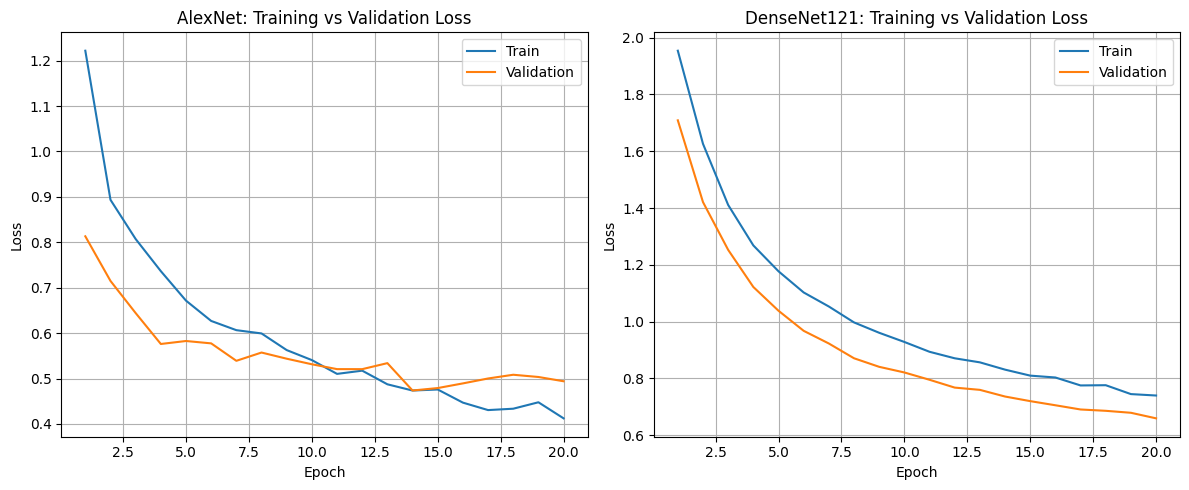


Final Accuracy Summary:
AlexNet - Train Accuracy: 86.01%, Validation Accuracy: 83.10%
DenseNet121 - Train Accuracy: 76.47%, Validation Accuracy: 75.77%


In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), alex_train_losses, label='Train')
plt.plot(range(1, NUM_EPOCHS + 1), alex_val_losses, label='Validation')
plt.title("AlexNet: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), dense_train_losses, label='Train')
plt.plot(range(1, NUM_EPOCHS + 1), dense_val_losses, label='Validation')
plt.title("DenseNet121: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Accuracy Summary:")
print(f"AlexNet - Train Accuracy: {alex_train_accs[-1]:.2f}%, Validation Accuracy: {alex_val_accs[-1]:.2f}%")
print(f"DenseNet121 - Train Accuracy: {dense_train_accs[-1]:.2f}%, Validation Accuracy: {dense_val_accs[-1]:.2f}%")



--- Generating Confusion Matrices ---


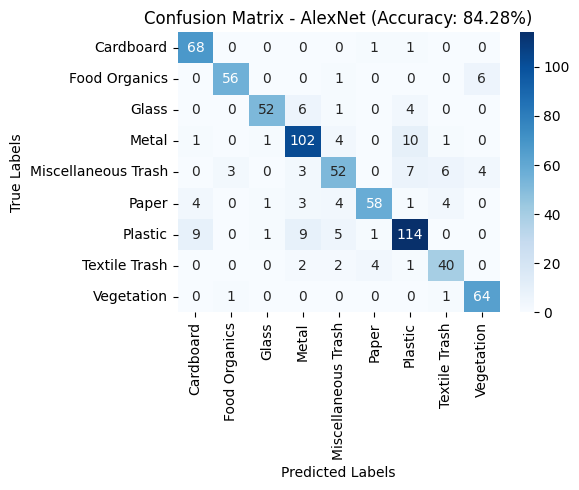

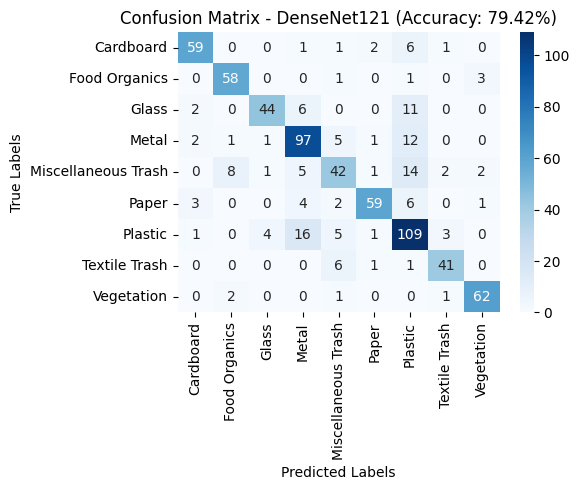

In [42]:
def plot_confusion_matrix(model, model_name, model_path, test_loader, class_names):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = 100 * np.trace(cm) / np.sum(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name} (Accuracy: {acc:.2f}%)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

print("\n--- Generating Confusion Matrices ---")
plot_confusion_matrix(alexnet, "AlexNet", "alexnet_finetuned.pth", test_loader, train_dataset.classes)
plot_confusion_matrix(densenet, "DenseNet121", "densenet121_finetuned.pth", test_loader, train_dataset.classes)
